In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# author: Ji Liu email: ji.liu@anl.gov

import itertools, numpy, qiskit
import circuit_cutter
import mlrecon_methods as ml

import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, H_distance_dict, total_counts

Untimigated distribution

In [4]:
unmiti_dist = {'00000': 0.0030625,
 '00001': 0.01659375,
 '10000': 0.01428125,
 '10001': 0.06196875,
 '10010': 0.02559375,
 '10011': 0.01125,
 '10100': 0.07671875,
 '10101': 0.4980625,
 '10110': 0.00859375,
 '10111': 0.02121875,
 '11000': 0.0099375,
 '11001': 0.01984375,
 '11010': 0.00321875,
 '11011': 0.0045,
 '11100': 0.00665625,
 '11101': 0.0154375,
 '11110': 0.0016875,
 '11111': 0.00296875,
 '00010': 0.00684375,
 '00011': 0.0028125,
 '00100': 0.018875,
 '00101': 0.12825,
 '00110': 0.00271875,
 '00111': 0.00484375,
 '01000': 0.00528125,
 '01001': 0.010375,
 '01010': 0.00196875,
 '01011': 0.00284375,
 '01100': 0.00328125,
 '01101': 0.00759375,
 '01110': 0.000875,
 '01111': 0.00184375}

In [5]:
unmiti_dist['10101']

0.4980625

In [6]:
#miti q0:
miti_q0_dist = {'00000': 0.0008425688019963411,
 '01000': 0.00029296464250364935,
 '10000': 0.005517728278129252,
 '11000': 0.0008495865288482616,
 '10010': 0.009557865665057726,
 '11010': 0.00011979923194458203,
 '10100': 0.06206853165414746,
 '11100': 0.003947297092526912,
 '10110': 0.009785446610530138,
 '11110': 0.0005213892995868953,
 '00010': 0.0031092465877714894,
 '01010': 7.483798837566549e-05,
 '00100': 0.011606112342791098,
 '01100': 0.00146082241758777,
 '00110': 0.002777216793237879,
 '01110': 0.00019042180022025817,
 '00001': 0.019392526241271156,
 '01001': 0.0057443316847119,
 '10001': 0.06391632957338894,
 '11001': 0.011123026516999339,
 '10011': 0.0023778911658138384,
 '11011': 0.00045629778819690383,
 '10101': 0.5645739481099143,
 '11101': 0.016009989387912097,
 '10111': 0.02297261740880418,
 '11111': 0.0011256606608771992,
 '00011': 0.0003923078813631954,
 '01011': 0.00016058132743087563,
 '00101': 0.16515115027382174,
 '01101': 0.00752785064048203,
 '00111': 0.0060325019932496535,
 '01111': 0.00032115361050720075}

In [7]:
#miti q1:
miti_q1_dist = {'00000': 0.0049653598742532305,
 '01000': 0.0006505747318370273,
 '00001': 0.0206545122554311,
 '01001': 0.004945107819417521,
 '10001': 0.06174996368704016,
 '11001': 0.009567380317862712,
 '00101': 0.1933852066281297,
 '01101': 0.008804537212156247,
 '10101': 0.5764269302146358,
 '11101': 0.016113215288272018,
 '10000': 0.01846072432857463,
 '11000': 0.0023432799733195007,
 '00100': 0.020213268590082344,
 '01100': 0.0016252662961490228,
 '10100': 0.05641478049926081,
 '11100': 0.0036798922835781338}

In [8]:
#miti q2:
miti_q2_dist = {'00000': 0.0007307208180306509,
 '00100': 0.022210962841427893,
 '00001': 0.005353756230944865,
 '00101': 0.17536109996316238,
 '10000': 0.004333075277128686,
 '10100': 0.07603325224215804,
 '10001': 0.03306194359049275,
 '10101': 0.592670046884051,
 '10010': 0.006007177300611289,
 '10110': 0.01091069320003823,
 '10011': 0.004290798563499355,
 '10111': 0.02269858456944508,
 '11000': 0.000479512452982136,
 '11100': 0.0017721435598688302,
 '11001': 0.007821077665541576,
 '11101': 0.01270606380073602,
 '11010': 2.1974251729679483e-05,
 '11110': 0.00038462517303646665,
 '11011': 0.00014626502991052148,
 '11111': 9.153886125403737e-05,
 '00010': 0.0019126205174269319,
 '00110': 0.0031884495847766298,
 '00011': 0.0009337891849845806,
 '00111': 0.006067421218165642,
 '01000': 0.00018970155902379144,
 '01100': 0.0005772141863509325,
 '01001': 0.0036672423597316054,
 '01101': 0.006252709135676439,
 '01010': 2.4057384965945976e-05,
 '01110': 6.778691682292703e-06,
 '01011': 3.589999345514637e-05,
 '01111': 5.880390771058424e-05}

In [9]:
#miti q3:
miti_q3_dist = {'00000': 0.005984192016901224,
 '00100': 0.025363116817725264,
 '00001': 0.018563723954829643,
 '00101': 0.1728787970868529,
 '00011': 0.0029726634182245817,
 '00111': 0.007395234250907539,
 '10001': 0.05985201819899007,
 '10101': 0.5333937884568029,
 '10011': 0.00895802996997104,
 '10111': 0.021547071443084213,
 '00010': 0.008044473598554727,
 '00110': 0.004078600568571452,
 '10000': 0.01624224263866314,
 '10100': 0.0767537926624765,
 '10010': 0.024101133733037645,
 '10110': 0.013871121184407104}

In [10]:
#miti q4:
miti_q4_dist = {'00000': 9.783043175724626e-05,
 '10000': 0.005135927816629799,
 '00100': 0.00040916101340379804,
 '10100': 0.05119589461907852,
 '00010': 0.0001646112964508514,
 '10010': 0.006332754670209209,
 '00110': 2.44884473536488e-05,
 '10110': 0.02331656800371775,
 '01010': 2.3886368975988558e-05,
 '11010': 9.744904881802676e-05,
 '01110': 0.00010689714391425332,
 '11110': 0.0006442917855116173,
 '00011': 0.00060959881039227,
 '10011': 0.026000038216052002,
 '00111': 0.0021359167063795376,
 '10111': 0.16914174119418712,
 '01011': 0.000276031244978137,
 '11011': 0.001436737974435057,
 '01111': 0.0005911793638376277,
 '11111': 0.004650544661738176,
 '01000': 6.331494229546442e-05,
 '11000': 0.00021533870223753462,
 '01100': 0.00010445590858859957,
 '11100': 0.0010985106941588543,
 '00001': 0.0015791436324456185,
 '10001': 0.054940809851308524,
 '00101': 0.0070856038509032266,
 '10101': 0.6191954107657333,
 '01001': 0.0008922793331805622,
 '11001': 0.0040608414370297335,
 '01101': 0.002094447994487824,
 '11101': 0.01627829406981016}

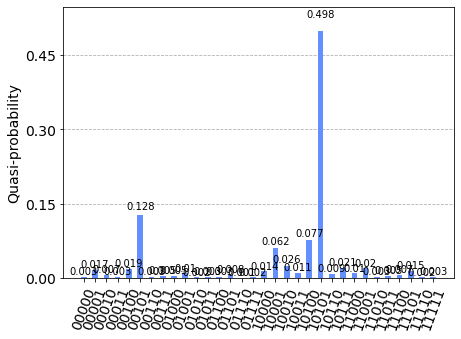

In [11]:
plot_histogram(unmiti_dist)

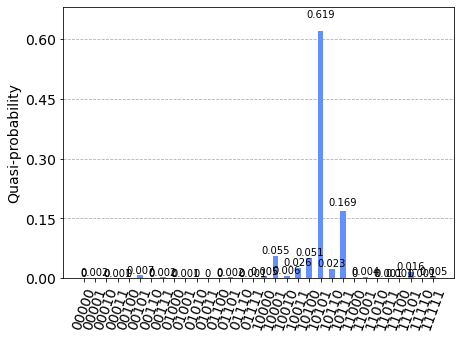

In [12]:
plot_histogram(miti_q4_dist)

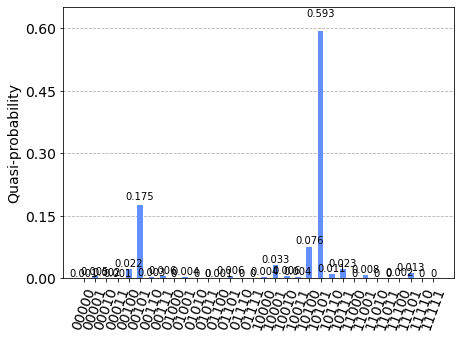

In [13]:
plot_histogram(miti_q2_dist)

In [14]:
qubits = 5
# list of all possible measurement outcomes (bitstrings)
all_bits = [ "".join(bits) for bits in itertools.product(["0","1"], repeat = qubits) ]

In [15]:
miti_dist_list = [miti_q0_dist, miti_q1_dist, miti_q2_dist, miti_q3_dist, miti_q4_dist]

In [16]:
def load_probs(miti_dist_list, bit_str):
    output_list = []
    for dist in miti_dist_list:
        try:
            miti_count = dist[bit_str]
        except:
            miti_count = 0
        output_list.append(miti_count)
    return output_list

In [17]:
load_probs(miti_dist_list, '10101')

[0.5645739481099143,
 0.5764269302146358,
 0.592670046884051,
 0.5333937884568029,
 0.6191954107657333]

In [18]:
#q0 bitflip
load_probs(miti_dist_list, '10100')

[0.06206853165414746,
 0.05641478049926081,
 0.07603325224215804,
 0.0767537926624765,
 0.05119589461907852]

In [19]:
#q1 bitflip
load_probs(miti_dist_list, '10111')

[0.02297261740880418,
 0,
 0.02269858456944508,
 0.021547071443084213,
 0.16914174119418712]

In [20]:
#q2 bitflip
load_probs(miti_dist_list, '10001')

[0.06391632957338894,
 0.06174996368704016,
 0.03306194359049275,
 0.05985201819899007,
 0.054940809851308524]

In [21]:
#q3 bitflip
load_probs(miti_dist_list, '11101')

[0.016009989387912097,
 0.016113215288272018,
 0.01270606380073602,
 0,
 0.01627829406981016]

In [22]:
#q4 bitflip
load_probs(miti_dist_list, '00101')

[0.16515115027382174,
 0.1933852066281297,
 0.17536109996316238,
 0.1728787970868529,
 0.0070856038509032266]

In [23]:
def combine_distribution(unmiti_dist, miti_dist_list):
    #given the mitigated distribution and the unmitigated distribution, return the combined distribution
    comb_dist = {}
    for bit_str in unmiti_dist.keys():
        probs_list = load_probs(miti_dist_list, bit_str)
        higher_count = 0
        lower_count = 0

        actual_count = unmiti_dist[bit_str]
    #     except:
    #         actual_count = 0
        for prob in probs_list:
            if prob > actual_count:
                higher_count += 1
            else:
                lower_count += 1
        miti_count = 0
        print(bit_str, "#higher", higher_count, "#lower", lower_count)
        if higher_count >= lower_count:
            miti_count = max(probs_list)
        else:
            miti_count = min(probs_list)
        comb_dist[bit_str] = miti_count
    return comb_dist
    

In [24]:
def avg_distribution(unmiti_dist, miti_dist_list):
    #given the mitigated distribution and the unmitigated distribution, return the combined distribution
    comb_dist = {}
    for bit_str in unmiti_dist.keys():
        probs_list = load_probs(miti_dist_list, bit_str)

        actual_count = sum(probs_list)/len(probs_list)
        comb_dist[bit_str] = actual_count
    return comb_dist

In [25]:
def bit_weight(dist, index):
    #bitwise distribution
    weight_0 = 0
    weight_1 = 0
    for key in dist.keys():
        if key[len(key) - 1 - index] == '0':
            weight_0 += dist[key]
        elif key[len(key) - 1 - index] == '1':
            weight_1 += dist[key]
        else:
            print("Incorrect key value")
    return weight_0, weight_1

In [26]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q0_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.11272183573525539 1xxxx 0.8872781642647447
x0xxx 0.9400247641870323 x1xxx 0.05997523581296767
xx0xx 0.12392788990380313 xx1xx 0.8760721100961969
xxx0x 0.9500739893812885 xxx1x 0.04992601061871153
xxxx0 0.22507659502732189 xxxx1 0.774923404972678


In [27]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q1_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.10835314657705471 1xxxx 0.8916468534229453
x0xxx 0.9999999999999999 x1xxx 0
xx0xx 0.12333690298773588 xx1xx 0.876663097012264
xxx0x 0.9522707460774077 xxx1x 0.04772925392259218
xxxx0 0.25524383340745616 xxxx1 0.7447561665925437


In [28]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q2_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.1287829590412384 1xxxx 0.8712170409587615
x0xxx 0.9432205225673077 x1xxx 0.056779477432692405
xx0xx 0.0690096121804595 xx1xx 0.9309903878195406
xxx0x 0.9657643919863439 xxx1x 0.03423560801365601
xxxx0 0.2265712275775163 xxxx1 0.7734287724224839


In [29]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q3_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.17443867322033707 1xxxx 0.8255613267796629
x0xxx 0.9090316718332416 x1xxx 0.0909683281667583
xx0xx 0.14471847752917208 xx1xx 0.8552815224708279
xxx0x 1.0 xxx1x 0
xxxx0 0.24528080171256733 xxxx1 0.7547191982874327


In [30]:
for i in range(0,5):
    # sum(xxxx0), sum(xxxx1)
    text0, text1 = list('xxxxx'),list('xxxxx')
    text0[i], text1[i] = '0', '1'
    w0, w1 = bit_weight(miti_q4_dist, i)
    print("".join(text0), w0, "".join(text1), w1)

0xxxx 0.08903138089310117 1xxxx 0.9109686191068989
x0xxx 0.7644472650630487 x1xxx 0.23555273493695125
xx0xx 0.10192659377719601 xx1xx 0.898073406222804
xxx0x 0.9673654993260024 xxx1x 0.03263450067399762
xxxx0 0.016258846489344655 xxxx1 0.9837411535106554


In [37]:
def update_dist(unmiti_dist, miti_dist, index):
    Ppost = {}
    w0, w1 = bit_weight(miti_dist, index)
    u_w0, u_w1 = bit_weight(unmiti_dist, index)
    if w0 == 0:
        w0 = 0.0000000000001
        w1 = 0.9999999999999
    if w1 == 0:
        w1 = 0.0000000000001
        w0 = 0.9999999999999
    if u_w0 == 0:
        u_w0 = 0.0000000000001
        u_w1 = 0.9999999999999
    if u_w1 == 0:
        u_w1 = 0.0000000000001
        u_w0 = 0.9999999999999
        
    for key in unmiti_dist.keys():
        if key[len(key) - 1 - index] == '0':
            Ppost[key] = unmiti_dist[key] / u_w0 * (w0)# / w1)
            #print(w0, w1, w0/w1, Ppost[key])
        elif key[len(key) - 1 - index] == '1':
            Ppost[key] = unmiti_dist[key] / u_w1 * (w1)# / w0)
            #print(w0, w1, w1/w0, Ppost[key])
        else:
            print("Incorrect key value")
    return Ppost

In [38]:
def combine_dist(orign_dist, dist_list):
    output_dist = {}
    for key in orign_dist:
        value = orign_dist[key]
        for dist in dist_list:
            value += dist[key]
        output_dist[key] = value
    return output_dist  

In [39]:
def bayesian_reconstruct(unmiti_dist, miti_dist_list, threshold = 0.0001):
    temp_dist = unmiti_dist.copy()
    h_dist = 1
    while h_dist > threshold:
        temp_dist_start = temp_dist.copy()
        ppost = [0] * len(miti_dist_list)
        for i in range(0, len(miti_dist_list)):
            ppost[i] = update_dist(temp_dist, miti_dist_list[i][0], miti_dist_list[i][1])
        temp_dist = combine_dist(temp_dist, ppost)
        temp_dist = norm_dict(temp_dist)
        h_dist = H_distance_dict(temp_dist, temp_dist_start)
        print("H-dist:", h_dist)
    return temp_dist

In [40]:
def norm_dict(dictionary):
    total = total_counts(dictionary)
    norm_dist = {}
    for i in dictionary.keys():
        norm_dist[i] = dictionary[i]/total
    return norm_dist

In [46]:
miti_dist_index = [[miti_q0_dist,0], [miti_q1_dist,1], [miti_q2_dist,2], [miti_q3_dist,3], [miti_q4_dist,4]]

In [47]:
post_dist = bayesian_reconstruct(unmiti_dist, miti_dist_index)

H-dist: 0.06020043741031447
H-dist: 0.04750691894763864
H-dist: 0.03873117525847813
H-dist: 0.03234962465680537
H-dist: 0.02751634376985576
H-dist: 0.02372958811649218
H-dist: 0.020676620152377305
H-dist: 0.018154989102357227
H-dist: 0.016029805027062045
H-dist: 0.014209167849631575
H-dist: 0.01262930010120713
H-dist: 0.011245156266362489
H-dist: 0.010024288043949838
H-dist: 0.008942740204977557
H-dist: 0.007982267568035582
H-dist: 0.0071284432080755845
H-dist: 0.006369385520544266
H-dist: 0.005694922845944348
H-dist: 0.005096068132428129
H-dist: 0.004564709153278111
H-dist: 0.004093441984421757
H-dist: 0.0036754924174073
H-dist: 0.0033046844262722406
H-dist: 0.0029754275143654813
H-dist: 0.002682705573473098
H-dist: 0.0024220584034218436
H-dist: 0.00218955308338864
H-dist: 0.001981746113830363
H-dist: 0.0017956390890243674
H-dist: 0.0016286311648615068
H-dist: 0.0014784712861639173
H-dist: 0.0013432124581311377
H-dist: 0.0012211695780714885
H-dist: 0.0011108816526886297
H-dist: 0.0010

In [54]:
#the success probability after bayesian reconstruction
post_dist['10101']

0.8150484655778782

In [50]:
for i in range(0,5):
    w0, w1 = bit_weight(post_dist, i)
    print("{}th bit {}, {}".format(i, w0, w1))

0th bit 0.11271911395375626, 0.8872808860462437
1th bit 0.9999989531667047, 1.046833295325829e-06
2th bit 0.06900475435213325, 0.9309952456478666
3th bit 0.9999991499664523, 8.500335476303561e-07
4th bit 0.016261721223622128, 0.9837382787763778


In [51]:
for i in range(0,5):
    temp_dist = miti_dist_index[i]
    w0, w1 = bit_weight(temp_dist[0], temp_dist[1])
    print("{}th bit {}, {}".format(i, w0, w1))

0th bit 0.11272183573525539, 0.8872781642647447
1th bit 0.9999999999999999, 0
2th bit 0.0690096121804595, 0.9309903878195406
3th bit 1.0, 0
4th bit 0.016258846489344655, 0.9837411535106554
